# TorchVision Object Detection Finetuning Tutorial
For this tutorial, we will be finetuning a pre-trained Mask R-CNN model on the Penn-Fudan Database for Pedestrian Detection and Segmentation. It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection and instance segmentation model on a custom dataset.

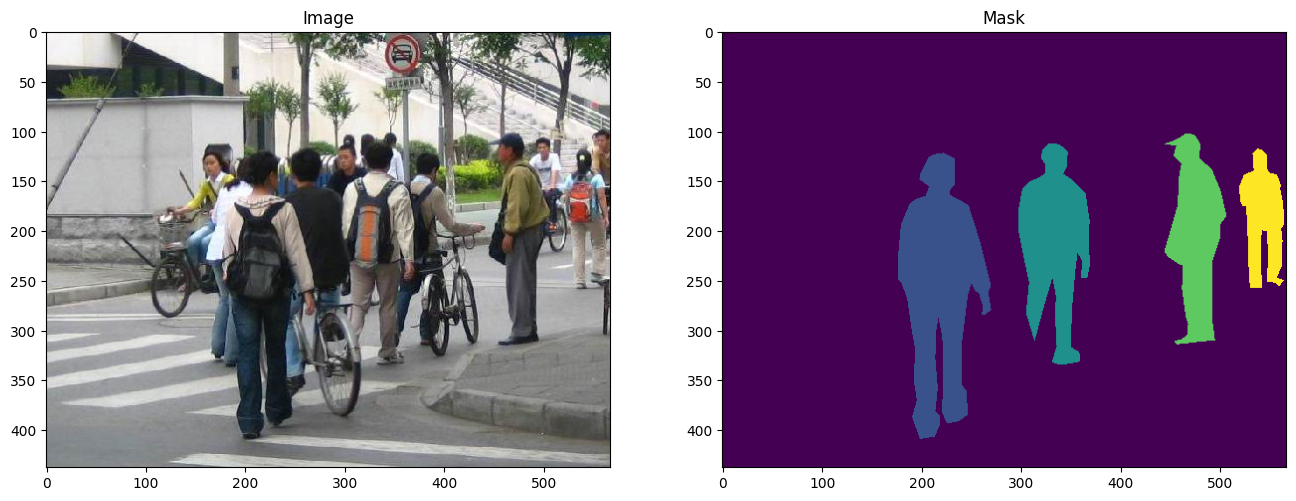

In [137]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

'''
Let's look at our training data...

We have the base image, as well as the segmentation mask which isolates the people in the image

170 images, 345 instances of Pedestrians
'''
image = read_image("./PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("./PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [138]:
import os
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
    '''
    For our custom datasets it will inherit from torch.utils.data.Dataset which is the base class
    for all datasets in PyTorch. Allowing it to be used with PyTorch's data loading utilities like
    DataLoader
    
    Note: When making labels for a dataset 0 is always the background class
    '''
    
    def __init__(self, root, transforms):
        '''
        __init__ constructor 
         
        root: The root directory of dataset
        transforms: A callable object (composition of transformations) to apply to the images and targets
        
        self.imgs: A sorted list of images filenames in the PNGImages directory
        self.masks: A sorted list of mask filenames in the PedMasks directory. Masks are used to indicate the regions of interest (e.g., pedestrians).
        '''
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx)-> tuple:
        '''
        __getitem__ Is called to retrive a single data sample(image, and its corresponding annotations) from 
                    the dataset
        
        return: Returns the transformed image and its corresponding annotations in a tuple
        
        (torchvision.tv_tensors.Image, target["boxes"]
                                       target["masks"] 
                                       target["labels"] 
                                       target["image_id"]
                                       target["area"]
                                       target["iscrowd"]
        '''
        
        '''         
        Loading Images and Masks
        
        img_path:   Constructs the full path to the image file
        mask_path:  Constructs the full path to the mask file
        read_image: Reads the image and mask into PyTorch tensors
        '''
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        
        '''
        Processing Masks
        
        obj_ids:    Constructs the full path to the image file
        obj_ids[1:] Removes the background ID
        num_objs:   Counts the number of pedestrians in the image
        '''
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        '''
        Creating Binary Masks
        
        mask = (mask == obj_ids[:, None, None]): Creates a binary mask for each pedestrian by comparing    
                                                 the mask tensor with each object ID
                                                 
        to(dtype=torch.uint8): Converts the boolean masj to a uint8 tensor 
        '''
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        '''
        Generating Bounding Boxes

        masks_to_boxes: Converts the binary masks into bounding boxes in the format [x_min, y_min, x_max, y_max]
        '''
        boxes = masks_to_boxes(masks)

        '''
        Labels and Metadata
        
        labels:   A tensor of labels for each pedestrian. Since there is only one class(pedestrians)
                  all labels are set to 1
        image_id: The index of the image in the dataset
        area:     The area of each bounding box, calculated as height * width
        iscrowd:  A tensor indicating whether each instance is a crowd(0 for non-crowd)
        '''        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        '''
        Wrapping Tensors
        
        tv_tensors.Image:         Wraps the image tensor in a torchvision image tensor
        tv_tensors.BoundingBoxes: Wraps the bounding boxes in a torchvision bounding box tensor
        tv_tensors.Mask:          Wraps the masks in a torchvision mark tensor
        target:                   A dictionary containing all the annotations(boxes, masks, albels)
        '''
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        '''
        Applying Transforms
        
        Applies the provided transformations(resizing, normalization) to the image and target
        '''
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        '''
        Returning the Sample
        
        Returns the transformed image and its corresponding annotations
        '''
        return img, target

    def __len__(self):
        '''
        __len__ Returns the total number of images in the dataset
        '''
        return len(self.imgs)

# Finetuning from a Pretrained Model
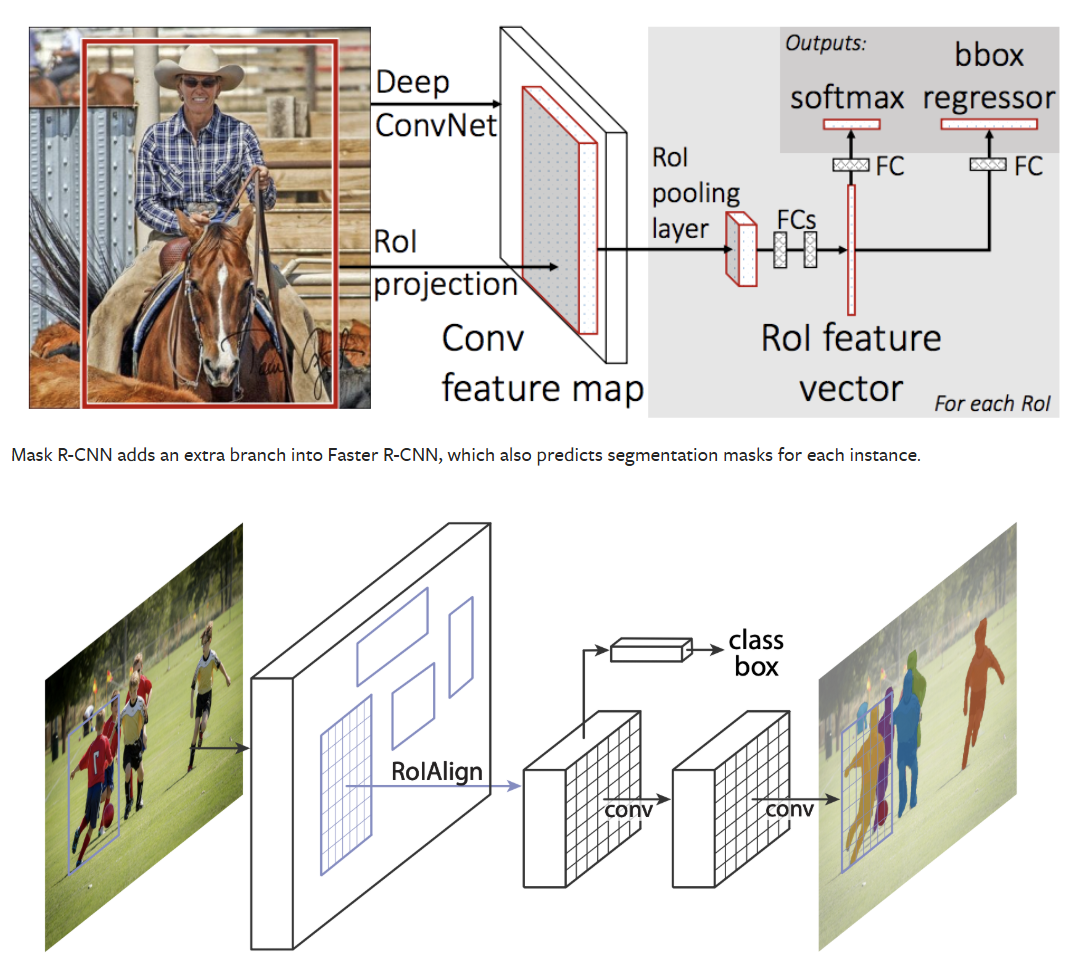 <br>
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:

In [139]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

'''
Loading a Pre-Trained Model

torchvision.models.detection.fasterrcnn_resnet50_fpn: 
    
    Loads a Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN)
    Faster R-CNN:      A popular object detection model that uses region proposals to detect objects
    ResNet-50:         A deep convolutional neural network architecture with 50 layers
    FPN:               A feature pyramid network that improves object detection at multiple scales
    
    weights="DEFAULT": Loads the model with pre-trained weights on the COCO Dataset (Common Objects in Context), 
                       DEFAULT ensures the last available weights are used



'''
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")


'''
Modifying the Classifier Head

The pre-trained model is designed for COCO dataset, which has 80 classes,
for our use case we replace it with our own classifier

num_classes:  The number of output classes for the custom task
1: Background Class
1: Foreground Class(Person)
'''
num_classes = 2 

'''
Get the Number of Input Features

model.roi_heads.box_predictor: Accesses the classifier and bounding box regressor head of the Faster R-CNN model.
cls_score:                     The final fully connected layer that predicts class scores.
in_features:                   The number of input features to the classifier. This is determined by the architecture of 
                               the model (e.g., 1024 for Faster R-CNN with ResNet-50 FPN).
'''
in_features = model.roi_heads.box_predictor.cls_score.in_features


'''
Replace the Classifier Head

FastRCNNPredictor:             A new classifier head is created with:
in_features:                   The number of input features (from the previous step).
num_classes:                   The number of output classes (2 in this case).
model.roi_heads.box_predictor: The original classifier head is replaced with the new one.
'''
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Modifying the Model to Add a Different Backbone

In [140]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

'''
Summary

This code builds a custom Faster R-CNN model using a MobileNetV2 backbone for object detection

It defines

backbone:           For feature extraction
anchor generator:   For the RPN
ROI Pooling Module: For extracting features from the region proposals

Model is configured with 2 classes, person, and background
'''

'''
Loading a Pre-Trained Backbone

torchvision.models.mobilenet_v2(weights="DEFAULT"): Loads a pre-trained MobileNetV2 model with the latest available weights.
MobileNetV2:                                        A lightweight and efficient convolutional neural network architecture.
.features:                                          Extracts only the feature extraction part of MobileNetV2 
                                                    (excluding the classification head).
backbone.out_channels = 1280:                       Sets the number of output channels for the backbone. For MobileNetV2, the 
                                                    final feature map has 1280 channels. This is required because Faster R-CNN 
                                                    needs to know the number of output channels in the backbone to properly configure its components.
'''
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

''''
Anchor Generator

AnchorGenerator:                  Generates anchor boxes for the RPN. Anchor boxes are used to propose regions that may contain objects.
sizes=((32, 64, 128, 256, 512),): Defines the sizes of the anchor boxes. Here, 5 sizes are specified
aspect_ratios=((0.5, 1.0, 2.0),): Defines the aspect ratios of the anchor boxes. Here, 3 aspect ratios are specified: 0.5 (wide), 1.0 (square), and 2.0 (tall).

This configuration generates 5 sizes × 3 aspect ratios = 15 anchors per spatial location in the feature map.
'''
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

'''
ROI(Regions of Interest) Pooling

featmap_names=['0']: Specifies which feature maps to use for ROI pooling. Here, only the feature map named '0' is used. If the backbone returns multiple feature maps, you can specify more names.
output_size=7:       The size of the output feature map after pooling. Here, each RoI is pooled to a 7x7 feature map.
sampling_ratio=2:    The number of sampling points used for bilinear interpolation during pooling. A higher value improves accuracy but increases computation.
'''
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

'''
Building the Faster R-CNN Model

FasterRCNN:                            Combines the backbone, RPN, and ROI pooling into a complete Faster R-CNN model
backbone:                              The feature extraction network (MobileNetV2 in this case).
num_classes=2:                         The number of output classes (1 foreground class + 1 background class).
rpn_anchor_generator=anchor_generator: The anchor generator for the RPN.
box_roi_pool=roi_pooler:               The ROI pooling module used to extract features from proposed regions.
'''
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Object Detection and Instance Segmentation Model for PennFudan Dataset

In [141]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    '''
    Load a pretrained Mask R-CNN model and modify the box predictor heads to adapt it for a 
    custom instance segmentation task
    '''
    
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

# Helper Functions for Data Augmentation / Transformation:

In [142]:
from torchvision.transforms import v2 as T

def get_transform(train):
    '''
    get_transform A function that returns a composition of image transformations, this is important
                  because it exposes variability to the dataset, flipping images 
    
    train: A boolean arguement that determines whether the transformations are for training
    '''
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Testing `forward()` Method
We do this because we want to get a idea of what the model expects during training on the sample data

In [143]:
def collate_fn(batch):
    '''
    collate_fn: Customize how batches of data are combined in a DataLoader
    '''
    return tuple(zip(*batch))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))

'''
Creating the DataLoader

DataLoader:            A PyTorch utility for loading data in batches.
dataset:               The dataset to load data from.
batch_size=2:          Loads 2 samples per batch.
shuffle=True:          Shuffles the data at the beginning of each epoch.
collate_fn=collate_fn: Uses the custom collate function to format the batch.
'''
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

'''
Training Setup

iter(data_loader): Creates an iterator from the DataLoader.
next(...):         Retrieves the next batch of data.
images:            A list of images in the batch.
targets:           A list of target dictionaries (containing bounding boxes, labels, etc.) corresponding to the images.
'''
images, targets = next(iter(data_loader))

'''
Preparing Images and Targets

Convert the tuple of images into a list
And then convert each target dictionary into a new dictionary. To ensure correct format
'''
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images, targets)  # Returns losses and detections, in the output dictionary

# Switch to evaluation mode
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions including boxes, labels, and confidence scores
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


# Perform the Training and Validation

In [144]:
import torchvision
import math
import sys
import torch
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from vision.references.detection.coco_eval import *
from torchvision import transforms
from vision.references.detection.engine import train_one_epoch
from vision.references.detection.engine import evaluate
import torch.nn as nn
import torch.optim as optim
'''
Summary 

1. Device Setup:            Determines whether to use a GPU or CPU.
2. Dataset Setup:           Loads and splits the Penn-Fudan Pedestrian dataset.
3. DataLoader Setup:        Creates data loaders for training and testing.
4. Model Setup:             Loads a Mask R-CNN model and moves it to the specified device.
5. Optimizer and Scheduler: Configures the optimizer and learning rate scheduler.
6. Training Loop:           Trains the model for 2 epochs and evaluates it on the test set.
'''

# Train on the GPU or CPU 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

'''
Dataset Setup

num_classes = 2:           The number of classes in the dataset (1 foreground class + 1 background class).
PennFudanDataset:          A custom dataset class for the Penn-Fudan Pedestrian dataset.
./PennFudanPed:            The root directory of the dataset.
get_transform(train=True): Applies training-specific transformations (e.g., random horizontal flip) to the dataset.
'''
num_classes = 2
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=True))

'''
Dataset Splitting

torch.randperm(len(dataset)): Generates a random permutation of indices for the dataset.
indices[:-50]:                Selects all but the last 50 indices for the training set.
indices[-50:]:                Selects the last 50 indices for the test set.
torch.utils.data.Subset:      Creates subsets of the dataset for training and testing.
'''
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

'''
DataLoader Setup

DataLoader:                  A PyTorch utility for loading data in batches.
dataset:                     The dataset to load data from.
batch_size=2:                Loads 2 samples per batch for training.
batch_size=1:                Loads 1 sample per batch for testing.
shuffle=True:                Shuffles the training data at the beginning of each epoch.
shuffle=False:               Does not shuffle the test data.
collate_fn=utils.collate_fn: Uses a custom collate function to format the batch.
'''
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

'''
Model Setup

get_model_instance_segmentation(num_classes): A helper function (defined elsewhere) that returns a Mask R-CNN model adapted for the custom task.
model.to(device):                             Moves the model to the specified device (GPU or CPU).
'''
model = get_model_instance_segmentation(num_classes)
model.to(device)

'''
Optimizer Setup

params:              Collects all model parameters that require gradients.
torch.optim.SGD:     Defines a Stochastic Gradient Descent (SGD) optimizer.
lr=0.005:            The learning rate.
momentum=0.9:        The momentum factor for accelerating convergence.
weight_decay=0.0005: L2 regularization term to prevent overfitting.
'''
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

'''
Learning Rate Scheduler

StepLR:      A learning rate scheduler that reduces the learning rate by a factor of gamma every step_size epochs.
step_size=3: Reduces the learning rate every 3 epochs.
gamma=0.1:   Multiplies the learning rate by 0.1 at each step.
'''
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

'''
Training Loop

num_epochs = 2:      Trains the model for 2 epochs.
train_one_epoch:     Trains the model for one epoch.
model:               The Mask R-CNN model.
optimizer:           The SGD optimizer.
data_loader:         The training data loader.
device:              The device (GPU or CPU) to use for training.
epoch:               The current epoch number.
print_freq=10:       Prints training progress every 10 iterations.
lr_scheduler.step(): Updates the learning rate at the end of each epoch.
evaluate:            Evaluates the model on the test dataset.
'''
num_epochs = 2
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\Users\User\Desktop\igait-video-precheck\Examples\vision\references\detection\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:00:33  lr: 0.000090  loss: 6.4709 (6.4709)  loss_classifier: 0.8535 (0.8535)  loss_box_reg: 0.1265 (0.1265)  loss_mask: 5.4422 (5.4422)  loss_objectness: 0.0450 (0.0450)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.5620  data: 0.0090  max mem: 2888
Epoch: [0]  [10/60]  eta: 0:00:19  lr: 0.000936  loss: 1.8842 (2.7223)  loss_classifier: 0.5672 (0.5338)  loss_box_reg: 0.3101 (0.2870)  loss_mask: 0.9266 (1.8711)  loss_objectness: 0.0219 (0.0240)  loss_rpn_box_reg: 0.0050 (0.0064)  time: 0.3995  data: 0.0182  max mem: 2888
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 0.9700 (1.7584)  loss_classifier: 0.2506 (0.3723)  loss_box_reg: 0.3101 (0.2760)  loss_mask: 0.2962 (1.0829)  loss_objectness: 0.0163 (0.0203)  loss_rpn_box_reg: 0.0071 (0.0070)  time: 0.3841  data: 0.0177  max mem: 2888
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.5424 (1.3615)  loss_classifier: 0.0996 (0.2800)  loss_box_reg: 0.1919 (0.2602)  loss_mask: 0.1939 (0.7976)  loss_ob

# What do the Predictions Look Like?
After one epoch of training, we obtain a COCO-style mAP > 50, and a mask mAP of 65.

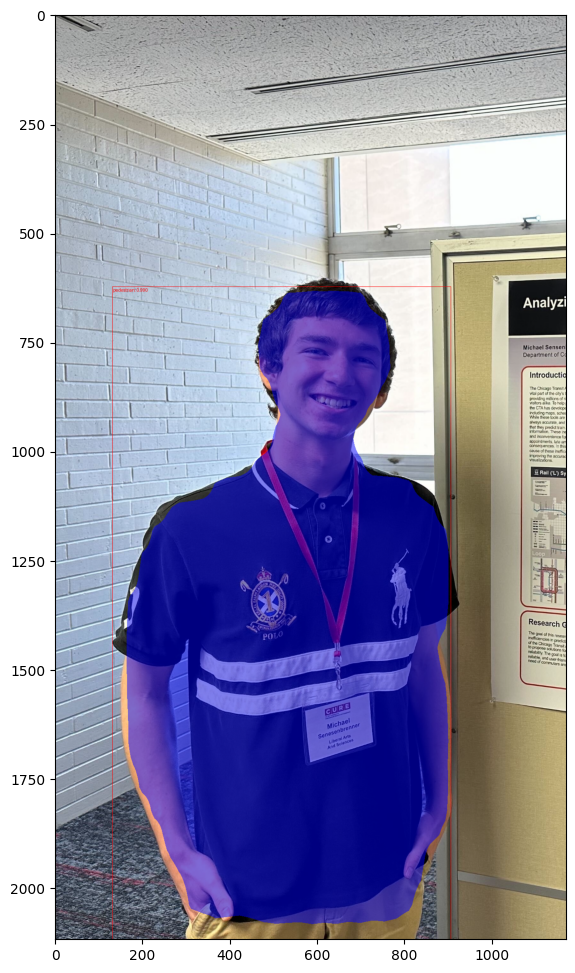

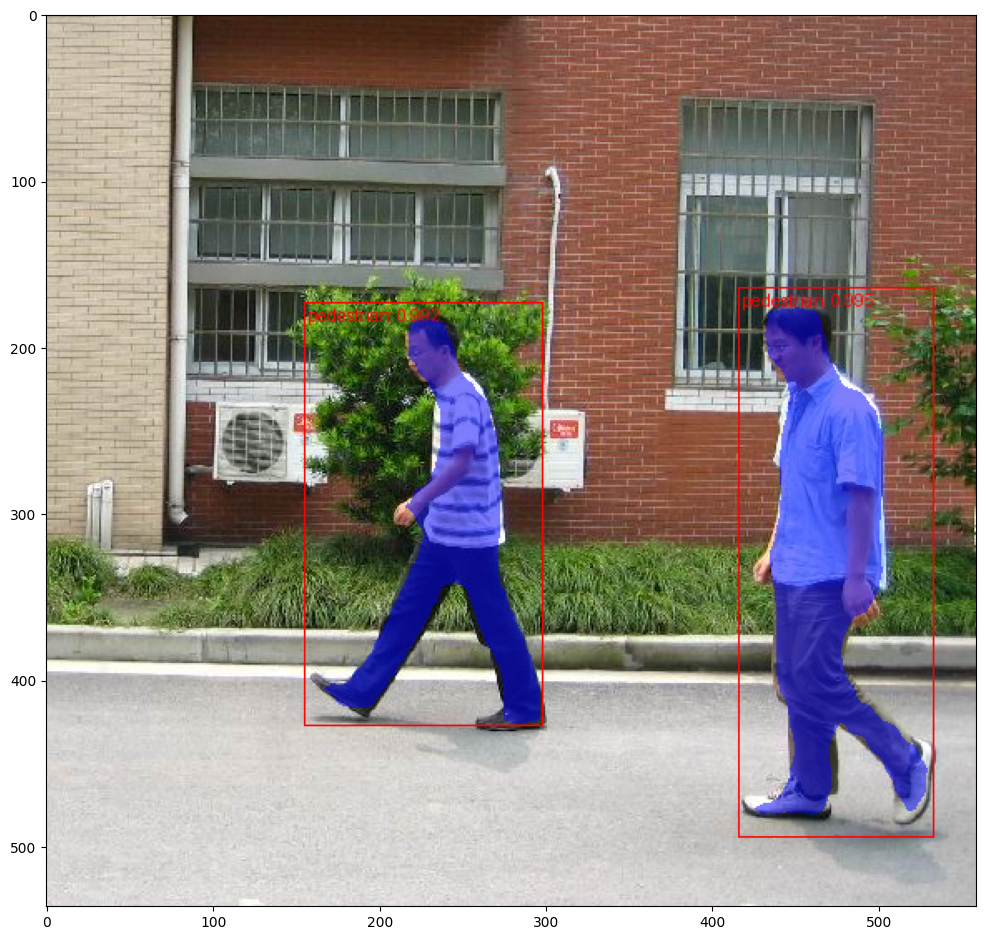

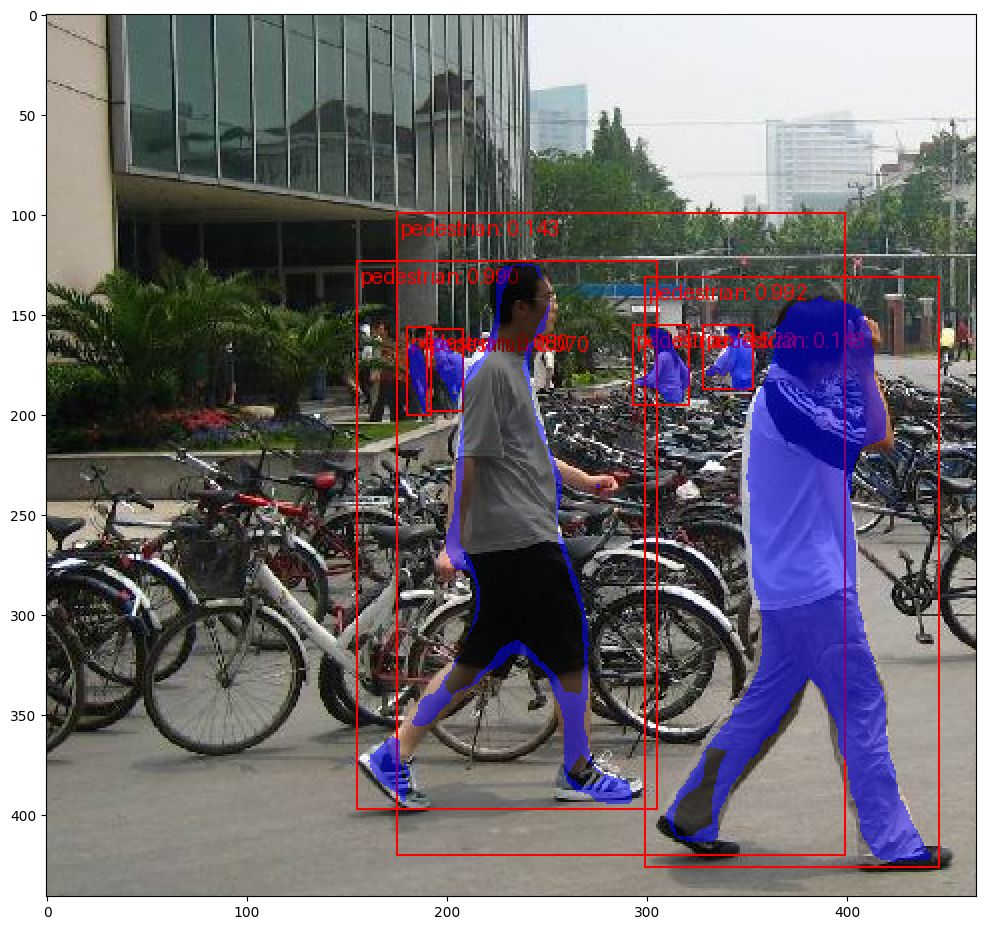

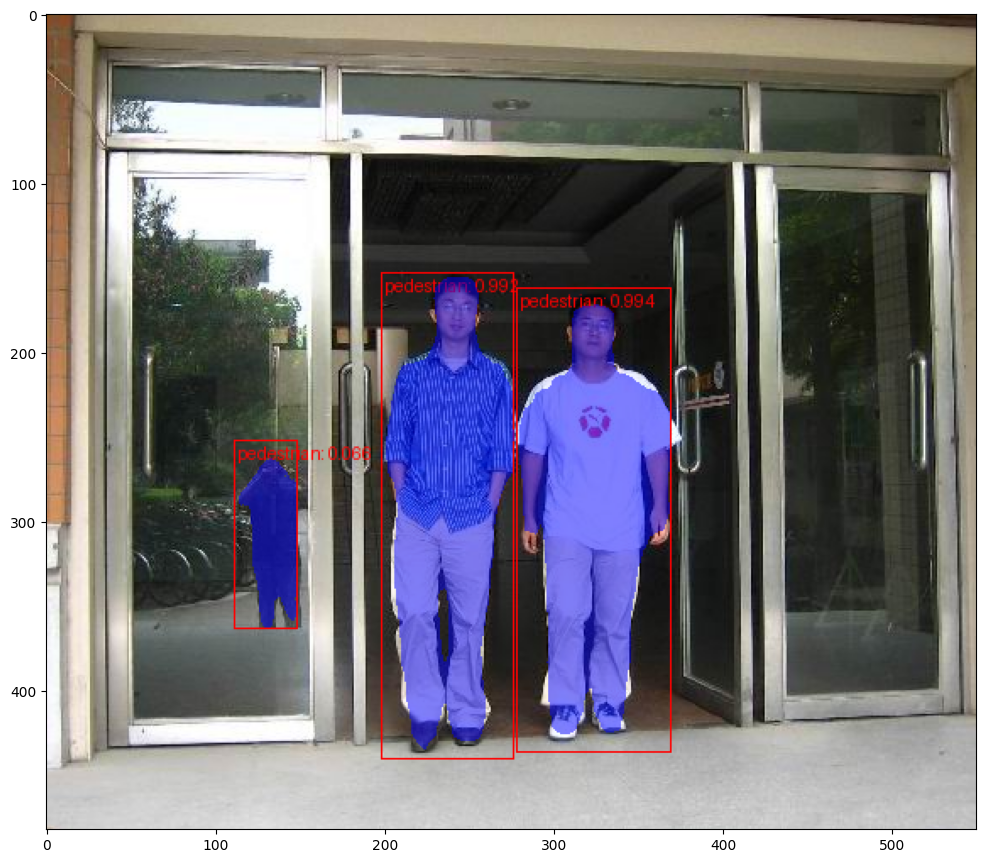

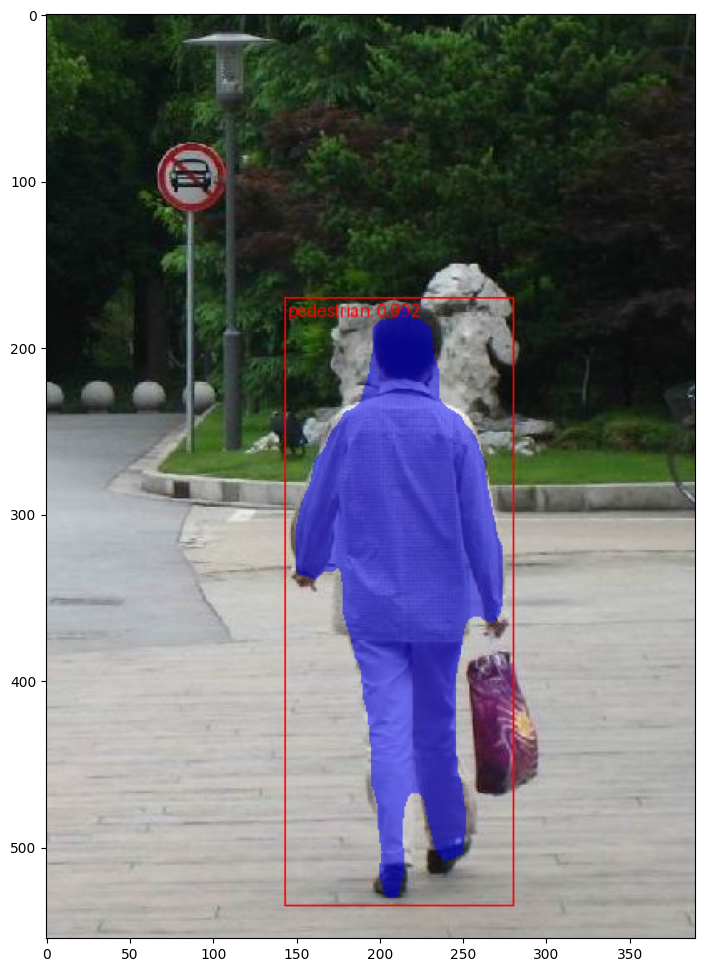

In [146]:

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Load the image into a tensor, we have images from 000001 - 00095
# image = read_image("./PennFudanPed/PNGImages/FudanPed00074.png")

def show_image(image):
    image = read_image(image)
    eval_transform = get_transform(train=False)
    # Set model to evaluation mode, and apply the predefined transformations to the image
    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        # Select first three channels(Red, Green, Blue), converting RGBA image to RGB, move to GPU
        x = x[:3, ...].to(device)
        # Pass through object detection model
        predictions = model([x, ])
        # Retrieve first prediction
        pred = predictions[0]

    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    # Create a list of labels for the detected objects formatting them as "pedestration scores"
    pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
    # Retrieve the bounding boxes of detected objects and convert them to integer coordinates
    pred_boxes = pred["boxes"].long()
    # Overlay the bounding boxes onto the image
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

    masks = (pred["masks"] > 0.7).squeeze(1)
    output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))
    
show_image("./Me.PNG")
show_image("./PennFudanPed/PNGImages/FudanPed00001.png")
show_image("./PennFudanPed/PNGImages/FudanPed00009.png")
show_image("./PennFudanPed/PNGImages/FudanPed00040.png")
show_image("./PennFudanPed/PNGImages/FudanPed00055.png")  